In [1]:
import torch
import torch.utils.data as torch_data

import losses
import trainer
from models import UNet
from utils import ColorizationDataset, colorfulness_metric
import random
import numpy as np

SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/dfbakin/.cache/pypoetry/virtualenvs/colorizer-C6ZZGchb-py3.12/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import matplotlib.pyplot as plt
import cv2

REQUIRED_SIZE = (256, 256)
combined_dataset = torch_data.ConcatDataset(
    [
        ColorizationDataset("datasets/coco_2017_test", resize=REQUIRED_SIZE, filter_colorless=True),
        # ColorizationDataset(
        #     "datasets/imagenet_classes", resize=REQUIRED_SIZE, classes_folders=True, filter_colorless=False
        # ),
    ]
)
print("Length:", len(combined_dataset))

100%|██████████| 40670/40670 [07:08<00:00, 94.84it/s] 

Length: 39566


Lenghths: 7914 395 31257
26.1552254154579


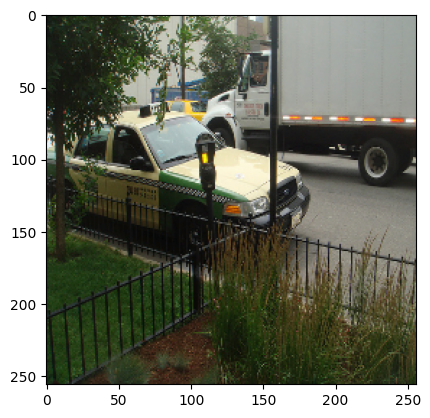

In [3]:
train_dataset, val_dataset, test_dataset = torch_data.random_split(
    combined_dataset, [0.2, 0.01, 0.79]
)  # debug lengths: 2034 407 38229
print("Lenghths:", *[len(item) for item in [train_dataset, val_dataset, test_dataset]])

L, ab = combined_dataset[0]
cielab_img = torch.cat([L * ColorizationDataset.l_norm_factor, ab * ColorizationDataset.ab_norm_factor], dim=0).numpy()
cielab_img = np.uint8(cielab_img.transpose(1, 2, 0))
rgb_img = cv2.cvtColor(cielab_img, cv2.COLOR_LAB2RGB)
print(colorfulness_metric(rgb_img))
plt.imshow(rgb_img)
plt.show()

In [51]:
batch_size = 10

train_loader = torch_data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=8
)
val_loader = torch_data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=8
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(1, 2).to(device)

criterion = torch.nn.HuberLoss(delta=(1.0 / ColorizationDataset.ab_norm_factor))
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
baseline_trainer = trainer.Trainer(
    model, optimizer, criterion, train_loader, val_dataloader=val_loader, device=device,
    scheduler=scheduler,
    use_logger=True
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /home/dfbakin/.netrc
wandb: Currently logged in as: dfbakin (colorizer-team) to https://api.wandb.ai. Use `wandb login --relogin` t

[Train: 2] loss: 0.801


val: 100%|██████████| 40/40 [00:06<00:00,  6.06it/s]

[Validation: 2] loss: 0.863


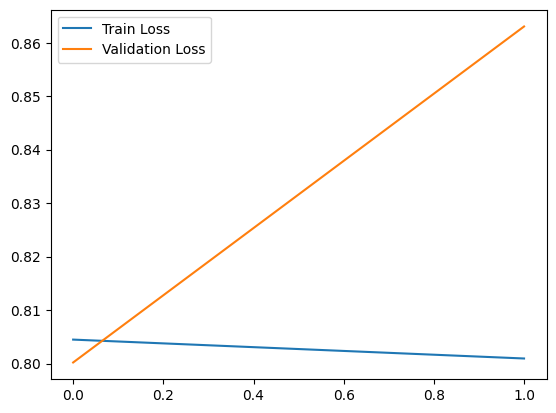

In [86]:
baseline_trainer.train(2)

torch.Size([1, 1, 256, 256]) torch.Size([1, 2, 256, 256])
(1, 256, 256, 3)
(1, 256, 256, 3)
torch.Size([1, 1, 256, 256]) torch.Size([1, 2, 256, 256])
(1, 256, 256, 3)
(1, 256, 256, 3)


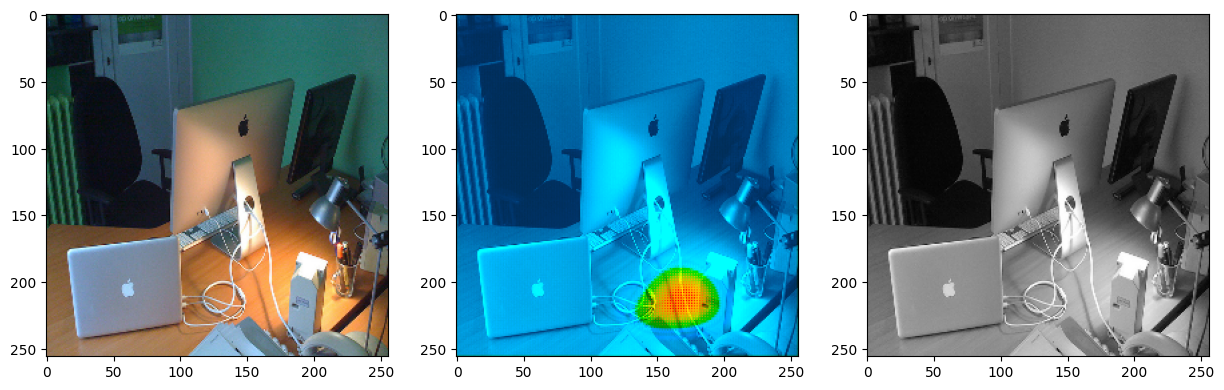

In [87]:
L, ab = train_dataset[92]

L = L.unsqueeze(0)
ab = ab.unsqueeze(0)

cielab_img_gt = ColorizationDataset.torch_L_ab_to_cvimage(L, ab)
with torch.no_grad():
    model.eval()
    ab_prediction = model.forward(L.to(device))

cielab_img_pred = ColorizationDataset.torch_L_ab_to_cvimage(L, ab_prediction.to("cpu"))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cielab_img_gt.squeeze(0))
ax[1].imshow(cielab_img_pred.squeeze(0))
ax[2].imshow(L.squeeze(0).numpy().transpose(1, 2, 0), cmap="gray")
plt.show()